**This kernel is based on MLPClassifier and KerasClassifier for Neural Networks**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import adam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report



Using TensorFlow backend.


**READING AND CLEANING DATA FOR MISSING VALUES**

In [2]:
train_titanic = pd.read_csv("../input/titanic/train.csv")
real_test_titanic = pd.read_csv("../input/titanic/test.csv")


*The test csv data has been named as real_test_titanic to avoid confusion later, while splitting the training data to train & test data for model building*

In [3]:
print("Dimension of training set : ", train_titanic.shape)
print("Dimension of test set : ", real_test_titanic.shape)


Dimension of training set :  (891, 12)
Dimension of test set :  (418, 11)


In [4]:
train_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
real_test_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


*The test data has been given to evaluate the survival column after finding a right model with train data*

**Dealing with missing values**
* Let us check whether there are any missing values (in both training set and test set)

In [6]:
#Check if there are any null values in training set

train_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**The age column has the most of missing values (177 in number).**

* Let's check if we can replace missing values with mean. 
* To know this we need to check whether the standard deviation is a higher value or lower value.
* Low standard deviation means, the age doesn't spread too much and the mean can be used to replace all the missing values
* Higher standard deviation means, the age spreads enough and we need to replace the missing age values with a spread

In [7]:
age_mean = int((round(train_titanic['Age'].mean(),2)))
age_sd = int(round(train_titanic['Age'].std(),2))
print("The mean of age : ", age_mean)
print("The standard deviation of age : ", age_sd)

The mean of age :  29
The standard deviation of age :  14


* The standard deviation is quite high
* As a workaround, we can generate 177 random numbers between 14 and 29 i.e.between sd and mean of age column and replace the NaN in age column with them

**The following code snippet will replace NaN in Age column with numbers in the range between sd and mean**

In [8]:
from random import choice
randomvalue = [i for i in range(age_sd,age_mean)]
for _ in range(train_titanic.isnull().sum().Age):
	number_to_insert = choice(randomvalue)
	train_titanic['Age'].fillna(number_to_insert, inplace = True) 

In [9]:
train_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* The other column which have missing values is 'Embarked'. Since it is only two in number, let us just replace it with most frequent one in that column
* 'Cabin' column is not used in analysis. So the missing values in there can be neglected

In [10]:
print("The most frequent value in 'Embarked' column is :", train_titanic['Embarked'].value_counts().idxmax())

The most frequent value in 'Embarked' column is : S


In [11]:
train_titanic['Embarked'] = train_titanic['Embarked'].fillna(train_titanic['Embarked'].value_counts().idxmax())
train_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Checking the same for test data

In [12]:
real_test_titanic.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Replace the NaN in Age column of test data (Similar to the one done for training data)


In [13]:
age_mean_test = int((round(real_test_titanic['Age'].mean(),2)))
age_sd_test = int(round(real_test_titanic['Age'].std(),2))
randomvalue = [i for i in range(age_sd_test,age_mean_test)]
for _ in range(real_test_titanic.isnull().sum().Age):
    number_to_insert = choice(randomvalue)
    real_test_titanic['Age'].fillna(number_to_insert, inplace = True)

In [14]:
real_test_titanic.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [15]:
real_test_titanic['Fare'] = real_test_titanic['Fare'].fillna(int(real_test_titanic['Fare'].mean()))

In [16]:
real_test_titanic.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

**BASIC PASSENGER DATA ANALYSIS**

In [17]:
#Total passengers and survival percentages based on gender
total_passengers = train_titanic['Sex'].count()
total_males = train_titanic['Sex'].value_counts()['male']
total_females = train_titanic['Sex'].value_counts()['female']
survived_males = train_titanic.query('Survived==1')['Sex'].value_counts()['male']
survived_females = train_titanic.query('Survived==1')['Sex'].value_counts()['female']
survived_total = survived_males + survived_females
print("=" * 70)
print("TRAINING SET ANALYSIS BASED ON GENDER")
print("=" * 70)
print("Total number of travellers : ",total_passengers )
print("Percentage of males : ", (100 * total_males /total_passengers))
print("Percentage of females : ", (100 * total_females /total_passengers))

print("=" * 70)
print("Total number of people survived : ", survived_total) 
print("Total number of survived males : ", survived_males )
print("Total number of survived females : ", survived_females)

print("=" * 70)
print("Percentage of males survived : ", 100 * (survived_males/total_passengers) )
print("Percentage of females survived : ", 100 * (survived_females/total_passengers))

print("=" * 70)
print("Percentage of total people survived : ", 100 * (survived_total/total_passengers)) 


#Total passengers and survival percentages based on passenger class
print("=" * 70)
print("*" * 70)
print("=" * 70)
total_1stclass_passengers = train_titanic['Pclass'].value_counts()[1]
total_2ndclass_passengers = train_titanic['Pclass'].value_counts()[2]
total_3rdclass_passengers = train_titanic['Pclass'].value_counts()[3]
survived_1stclass_passengers = train_titanic.query('Survived==1')['Pclass'].value_counts()[1]
survived_2ndclass_passengers = train_titanic.query('Survived==1')['Pclass'].value_counts()[2]
survived_3rdclass_passengers = train_titanic.query('Survived==1')['Pclass'].value_counts()[3]
print("TRAINING SET ANALYSIS BASED ON PASSENGER CLASS")
print("=" * 70)
print("Total number of first class passengers : ", total_1stclass_passengers )
print("Total number of second class passengers : ", total_2ndclass_passengers )
print("Total number of third class passengers : ", total_3rdclass_passengers )
print("=" * 70)
print("Total number of survived first class passengers : ", survived_1stclass_passengers )
print("Total number of survived second class passengers : ", survived_2ndclass_passengers )
print("Total number of survived third class passengers : ", survived_3rdclass_passengers )
print("Percentage of survived first class passengers : ", 100 * survived_1stclass_passengers/ total_passengers)
print("Percentage of survived second class passengers : ", 100 * survived_2ndclass_passengers/ total_passengers)
print("Percentage of survived first class passengers : ", 100 * survived_3rdclass_passengers/ total_passengers)
print("=" * 70)


TRAINING SET ANALYSIS BASED ON GENDER
Total number of travellers :  891
Percentage of males :  64.75869809203142
Percentage of females :  35.24130190796858
Total number of people survived :  342
Total number of survived males :  109
Total number of survived females :  233
Percentage of males survived :  12.2334455667789
Percentage of females survived :  26.15039281705948
Percentage of total people survived :  38.38383838383838
**********************************************************************
TRAINING SET ANALYSIS BASED ON PASSENGER CLASS
Total number of first class passengers :  216
Total number of second class passengers :  184
Total number of third class passengers :  491
Total number of survived first class passengers :  136
Total number of survived second class passengers :  87
Total number of survived third class passengers :  119
Percentage of survived first class passengers :  15.26374859708193
Percentage of survived second class passengers :  9.764309764309765
Percentage o

Text(0.5, 0, 'Gender')

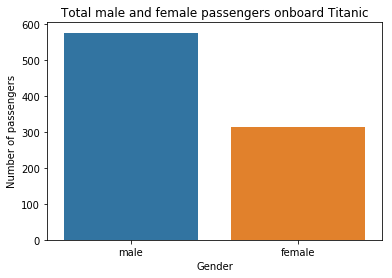

In [18]:
#Plotting to see distribution

sns.countplot('Sex', data=train_titanic, palette=None)
plt.title("Total male and female passengers onboard Titanic")
plt.ylabel("Number of passengers")
plt.xlabel("Gender")


**Inference from above diagram**
* Number of males way greater than number of females

Text(0.5, 0, 'Gender')

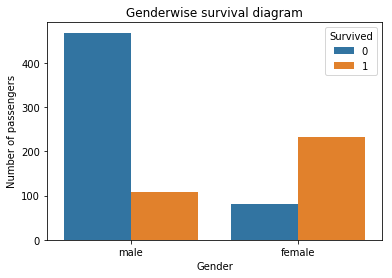

In [19]:
sns.countplot('Sex',data=train_titanic,hue='Survived')
plt.title("Genderwise survival diagram")
plt.ylabel("Number of passengers")
plt.xlabel("Gender")

**Inference drawn from above diagram** 
* Survived =  1, means the person survived the disaster
* Survival rate of females is higher than that of males

Text(0.5, 0, 'Gender')

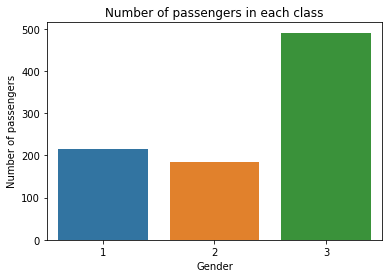

In [20]:
sns.countplot('Pclass',data=train_titanic)
plt.title("Number of passengers in each class")
plt.ylabel("Number of passengers")
plt.xlabel("Gender")

**Inference drawn from above diagram**
* Third class passengers are way ahead in number than that of first and second class passengers

Text(0.5, 0, 'Gender')

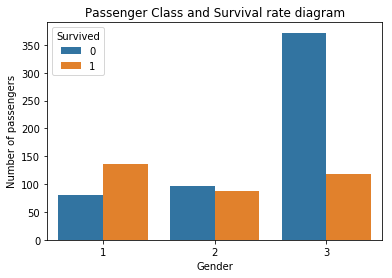

In [21]:
sns.countplot('Pclass',data=train_titanic,hue='Survived')
plt.title("Passenger Class and Survival rate diagram")
plt.ylabel("Number of passengers")
plt.xlabel("Gender")

**Inference drawn from above diagram**
* The survival rate of all threee classes passengers are more or less equal
* Still, priority is given to first class passengers during rescue operations
* Most of passengers in third class didn't survive the disaster

**DROPPING COLUMNS THAT ARE NOT USED IN FURTHER ANALYSIS**

In [22]:
train_titanic = train_titanic.drop(['Ticket', 'Cabin','Name'], axis=1)
real_test_titanic = real_test_titanic.drop(['Ticket', 'Cabin','Name'], axis=1)

In [23]:
train_titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [24]:
real_test_titanic.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [25]:
train_survived = train_titanic['Survived']

**For further analysis**
* **Replace 'male' with '1' and 'female' with '0' **
* **Replace Embarked column values  - S with '0', C with '1', Q with '2'**

In [26]:
train_titanic['Sex'] = train_titanic['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
train_titanic['Embarked'] = train_titanic['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [27]:
train_titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,0
4,5,0,3,1,35.0,0,0,8.0500,0


In [28]:
real_test_titanic['Sex'] = real_test_titanic['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
real_test_titanic['Embarked'] = real_test_titanic['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [29]:
real_test_titanic.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,2
1,893,3,0,47.0,1,0,7.0000,0
2,894,2,1,62.0,0,0,9.6875,2
3,895,3,1,27.0,0,0,8.6625,0
4,896,3,0,22.0,1,1,12.2875,0


**Make PassengeId as index column in both train and test data**

In [30]:
train_titanic = train_titanic.set_index('PassengerId')
real_test_titanic = real_test_titanic.set_index('PassengerId')

In [31]:
real_test_titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,7.8292,2
893,3,0,47.0,1,0,7.0000,0
894,2,1,62.0,0,0,9.6875,2
895,3,1,27.0,0,0,8.6625,0
896,3,0,22.0,1,1,12.2875,0


So, we now have our data set cleaned up and ready for machine learning algorithm analysis. Let's dive in by starting with Logistic Regression.

**MACHINE LEARNING ON TITANIC DATA**

**Train-Test Split**

*From here on real_test_titanic will be kept apart and used only for prediction. The test data that you see below is derived from train data for model building purpose*

In [32]:
X = train_titanic.drop(['Survived'], axis = 1)
y = train_titanic["Survived"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)
print("Dimension of Train data :", x_train.shape)
print("Dimension of Test data :", x_test.shape)

Dimension of Train data : (801, 7)
Dimension of Test data : (90, 7)


*The train test ratio selected is 90:10*

**NEURAL NETWORK USING MLP CLASSIFIER**

Before starting the process, the input data set is scaled using MinMaxScaler(). Default setting of MinMaxScaler is to bring down multi-range values to values between 0 and 1

In [33]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Let's try the MLPClassifier without any hyperparameter tuning and using some randomnly selected values

In [34]:
mlp_model = MLPClassifier(hidden_layer_sizes=(150,150,150),activation ='relu', max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10, learning_rate = 'adaptive', momentum=0.9)

mlp_model.fit(x_train_scaled, y_train)
y_pred = mlp_model.predict(x_test_scaled)


Iteration 1, loss = 0.71637646
Iteration 2, loss = 0.71007861
Iteration 3, loss = 0.70401674
Iteration 4, loss = 0.69614917
Iteration 5, loss = 0.68761647
Iteration 6, loss = 0.68027252
Iteration 7, loss = 0.67364006
Iteration 8, loss = 0.66656285
Iteration 9, loss = 0.66196844
Iteration 10, loss = 0.65770757
Iteration 11, loss = 0.65486713
Iteration 12, loss = 0.65197817
Iteration 13, loss = 0.64960812
Iteration 14, loss = 0.64795287
Iteration 15, loss = 0.64562113
Iteration 16, loss = 0.64418481
Iteration 17, loss = 0.64364319
Iteration 18, loss = 0.64219488
Iteration 19, loss = 0.64001138
Iteration 20, loss = 0.63760625
Iteration 21, loss = 0.63577806
Iteration 22, loss = 0.63389737
Iteration 23, loss = 0.63204143
Iteration 24, loss = 0.63020834
Iteration 25, loss = 0.62808661
Iteration 26, loss = 0.62595180
Iteration 27, loss = 0.62450452
Iteration 28, loss = 0.62370066
Iteration 29, loss = 0.62319930
Iteration 30, loss = 0.62223627
Iteration 31, loss = 0.62065708
Iteration 32, los

In [35]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix \n', confusion)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Confusion Matrix 
 [[44  6]
 [14 26]]
Accuracy: 0.78


The above analysis shows that there is fairly decent accuracy of 78%. However, more insights can be drawn using hyperparameter optimization and running the model with best parameters

#### Hyperparameter Optimization for MLPClassifier

Start with defining the parameter values

In [36]:
classifier = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (100,100,100), (150,150,150), (200,200,200)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [37]:
model = GridSearchCV(classifier, parameter_space, n_jobs=-1, cv=3)
model.fit(x_train_scaled, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.05],
                         'hidden

In [38]:
print('Best parameters calculated :', model.best_params_)

Best parameters calculated : {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (150, 150, 150), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [39]:
predicted_y = model.predict(x_test_scaled)


In [40]:
confusion = confusion_matrix(y_test, predicted_y)
print('Confusion Matrix after hyperparameter optimization \n', confusion)
print('Accuracy after hyperparameter optimization: {:.2f}'.format(accuracy_score(y_test, predicted_y)))

Confusion Matrix after hyperparameter optimization 
 [[46  4]
 [10 30]]
Accuracy after hyperparameter optimization: 0.84


The above two analysis shows that there isn't much variation in accuracy scores and confusion matrices for both randomnly picked values and hyperparameter optimization values dont have much difference. Let us now see if these scores can be improved using Keras.

**NEURAL NETWORK USING KERAS**

Like in the previous analysis, let us start with performing a Keras Sequential classifier with randomnly selected values. The total number of hidden layers selected is 2 for simplicity with 10 and 15 nodes each. 

In [41]:
layer1 = Dense(units = 10,activation = 'relu', input_dim = 7)
layer2 = Dense(units = 15, activation = 'relu')
layer3 = Dense(units = 2, activation = 'sigmoid')

model = Sequential([layer1, layer2, layer3])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

clf = model.fit(x_train_scaled, y_train, batch_size = 25, epochs = 300)

Epoch 1/300
801/801 [==============================] - 0s 372us/step - loss: 0.6679 - accuracy: 0.5905
Epoch 2/300
801/801 [==============================] - 0s 59us/step - loss: 0.6262 - accuracy: 0.6367
Epoch 3/300
801/801 [==============================] - 0s 56us/step - loss: 0.5960 - accuracy: 0.6529
Epoch 4/300
801/801 [==============================] - 0s 58us/step - loss: 0.5682 - accuracy: 0.7041
Epoch 5/300
801/801 [==============================] - 0s 59us/step - loss: 0.5418 - accuracy: 0.7591
Epoch 6/300
801/801 [==============================] - 0s 57us/step - loss: 0.5201 - accuracy: 0.7915
Epoch 7/300
801/801 [==============================] - 0s 57us/step - loss: 0.5032 - accuracy: 0.7990
Epoch 8/300
801/801 [==============================] - 0s 56us/step - loss: 0.4915 - accuracy: 0.8002
Epoch 9/300
801/801 [==============================] - 0s 57us/step - loss: 0.4831 - accuracy: 0.8040
Epoch 10/300
801/801 [==============================] - 0s 56us/step - loss: 0.47

In [42]:
predicted_on_test = model.predict_classes(x_test_scaled, batch_size = 25)
confusion = confusion_matrix(y_test, predicted_on_test)
print('Confusion Matrix \n', confusion)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predicted_on_test)))

Confusion Matrix 
 [[47  3]
 [10 30]]
Accuracy: 0.86


The accuracy calculated with Keras Sequential classifier has got small increase than the previous MLPClassifier. The confusion matrix parameters shows some improvement than before

Clearly the above analysis indicates that Keras Sequential Classifier has a better performance. Let us now generate the required output on the actual test data. 

In [43]:
real_test_titanic_scaled = scaler.transform(real_test_titanic)

In [44]:
predicted_on_actual = model.predict_classes(real_test_titanic_scaled, batch_size = 25)

In [45]:
predicted_on_actual

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [46]:
actual_test = pd.read_csv("../input/titanic/test.csv")

for_submission = pd.DataFrame({"PassengerId": actual_test['PassengerId'],
                      "Survived":predicted_on_actual.astype(int)})
for_submission.to_csv("prediction_file_by_arunjith.csv",index=False)

We could also perform a hyperparameter tuning for Keras Classifier, but it would take much amount of time. 
The notebook can be improved by bringing in more classifier algorithms.